# Import, save and export data


In this notebook, we look at import functions and how to assign data to the grid. 

---

We import the class (as explained in turorial 1): 

In [1]:
import sys
sys.path.append('..')

from agrid.agrid import *
from agrid.acc import download

Now we make two grid objects, one of the Antarctic continent in  [EPSG:3031. WGS 84 / Antarctic Polar Stereographic projection](https://epsg.io/3031) and also a global model, using [WGS84](https://epsg.io/4326). Resolution is defined in the unit of the projection, meters for stereographic projection, and degrees for the global grid. The coordinates in the xarray dataset are stored as dask arrays, they are not loaded until they are needed. When processed, they are loaded as smaller chunks, 1/10 of the axes large. 

In [12]:
#Continental
ant = Grid(crs=3031, res = [10*km, 10*km], 
           left = -3100*km, up=3100*km, right = 3100*km, down = -3100*km, 
           set_frame = False)

print(ant.ds)

#Global (almost)
world = Grid(crs=4326, res = [1, 1], left = -180, up=90, right = 180, down = -90)

print(world.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 620, Y: 620, Z: 5)
Coordinates:
  * X        (X) float32 -3100000.0 -3089983.8 ... 3089983.8 3100000.0
  * Y        (Y) float32 3100000.0 3089983.8 3079967.8 ... -3089983.8 -3100000.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    YV       (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lat      (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lon      (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
Data variables:
    *empty*
<xarray.Dataset>
Dimensions:  (RGB: 3, X: 359, Y: 179, Z: 5)
Coordinates:
  * X        (X) float32 -180.0 -178.99721 -177.99442 ... 177.99721 179.0
  * Y        (Y) float32 89.0 87.994385 86.98876 ... -87.98876 -88.994385 -90.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X

We download a raster, in this case the global 1:50m Bathymetry. It is about 100Mb, so it might take a while.  

In [13]:
download('''https://www.naturalearthdata.com/http//
    www.naturalearthdata.com/download/50m/raster/HYP_50M_SR_W.zip''',
         '../../data/ne/HYP_50M_SR_W.zip')

File ../../data/ne/HYP_50M_SR_W.zip already exists.
Saved:  ../../data/ne/HYP_50M_SR_W.zip


{}

We import the raster to the global grid and to the Antarctic grid: 
The raster has three channels, so we assign it to X, Y and RGB coordinates. This might also take some time, as the raster needs to be warped to each grid cell. We can speed up a bit by subsampling the raster before warp. 

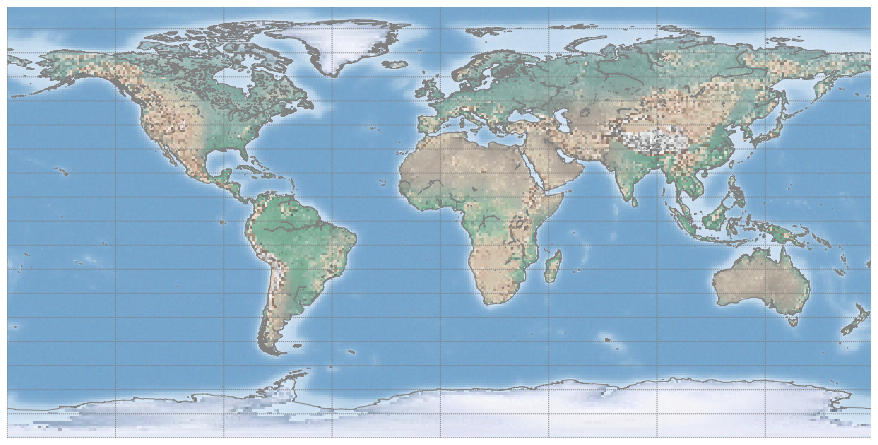

In [14]:
world.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                world.read_raster('../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif', sub_sampling=5) )
world.map_grid('RGB_RASTER')


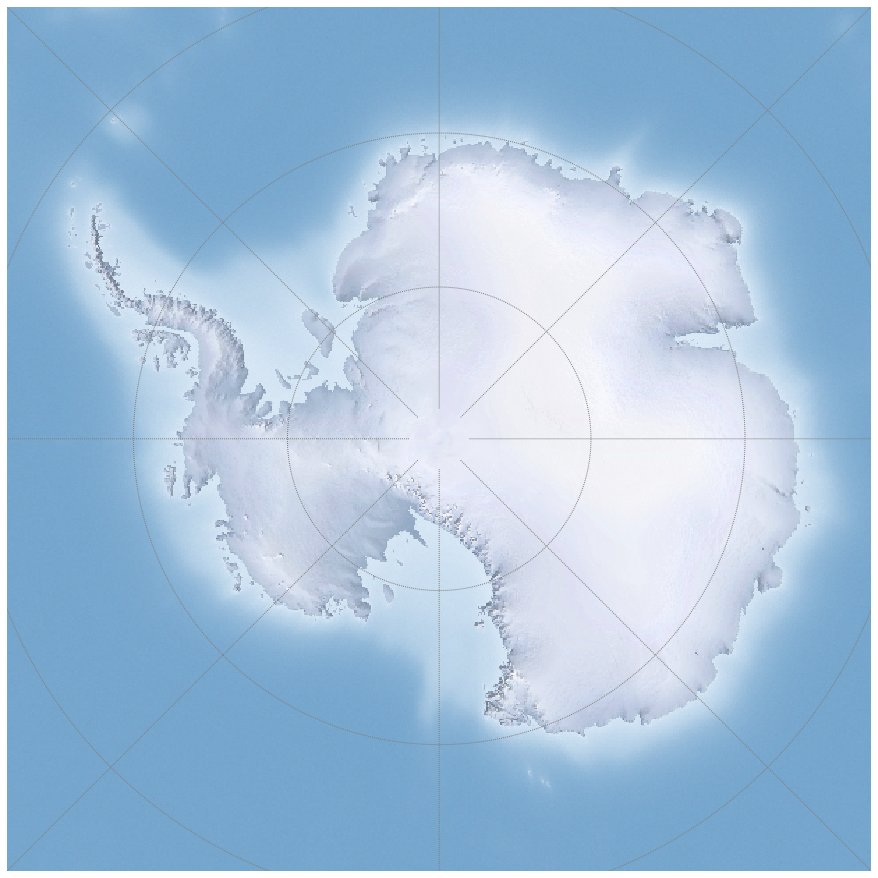

In [15]:
ant.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                        ant.read_raster('../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif', 
                                                           sub_sampling=3) )

ant.map_grid('RGB_RASTER', draw_coast=False)

The function read_raster returns a numpy array, that is assigned to the dataFrame and liked to coordinates (Y, X, and RGB). As explaned earlier, Y comes before X as arrays are indexed rows-columns. 

sub_sampling subsamples unnecisary large arrays before reprojecting. Source extra adds some extra cells around the margin to ensure that the dateline is correctely rendered. 

Pretty, but the raison d'etre for this code is to work properly with 3D models. We download AN-1S sesimic 3D model of the Antarctic lithosphere. 

In [16]:
download('http://www.seismolab.org/model/antarctica/lithosphere/AN1-S_depth_grd.tar.gz',
         '../../data/an/AN1-S_depth_grd.tar.gz')


File ../../data/an/AN1-S_depth_grd.tar.gz already exists.
Saved:  ../../data/an/AN1-S_depth_grd.tar.gz


{}

In [1]:
import glob

an_files = sorted(glob.glob('../../data/an/*.grd'))
#print(an_files)
ant.ds.coords['AN_Z'] = [np.float32(d[-9:-4])*km for d in an_files]
str_depths = [str(d[-9:-4]) for d in an_files]


an_array = np.empty((ant.nx, ant.ny, len(an_files)))
an_array[:] = np.nan
for i, a in enumerate(ant.ds.coords['AN_Z'].values):
    print(a//km, end=' ')
    fname = '../../data/an/AN1-S_hslice_%s.grd'%str_depths[i]
    if os.path.isfile(fname):
        an_array[:,:,i] = ant.read_grid(fname, xyz = ('x','y','z') ) 
    
ant.ds['AN_S'] = (('Y', 'X', 'AN_Z'), an_array)

NameError: name 'np' is not defined

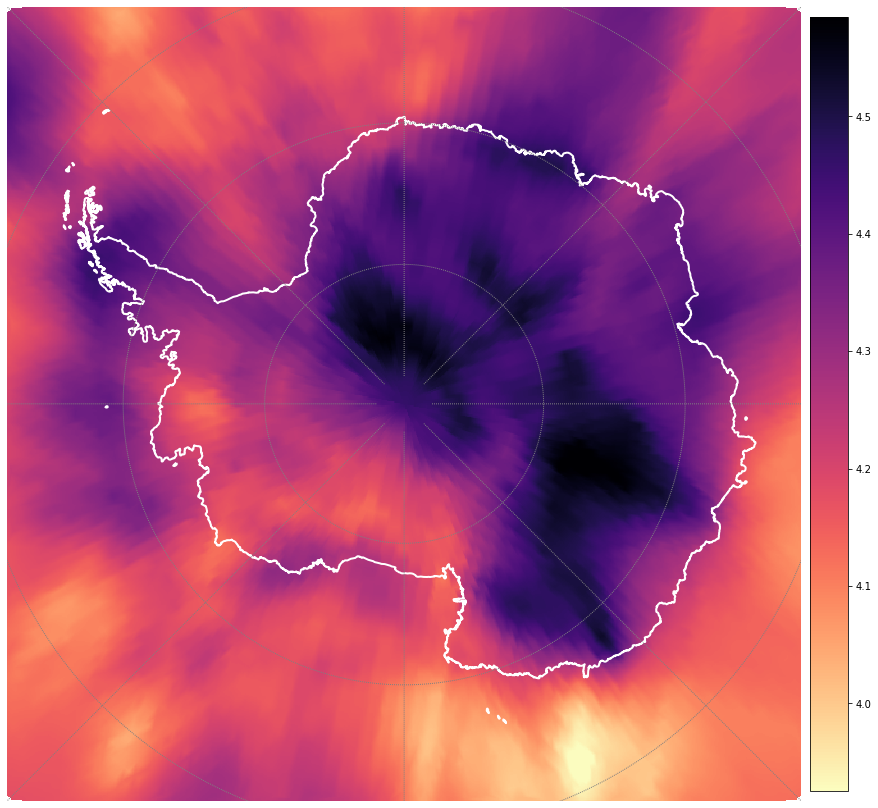

In [18]:
ant.map_grid(ant.ds['AN_S'].sel(AN_Z=150*km), cmap='magma_r', line_w=2, line_c='w', cbar=True)

Say we want to look at a 1D velocity model, e.g. [AK135, Kennett, Engdahl & Buland (1995)](http://rses.anu.edu.au/seismology/ak135/ak135f.html). We can read directely from IRIS url and import it to our grid: 

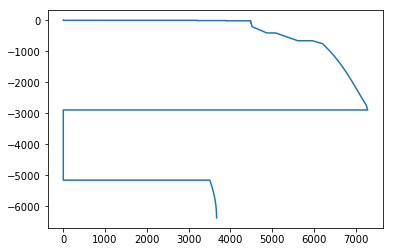

In [19]:
url_ak135 = 'http://ds.iris.edu/files/products/emc/data/AK135F/AK135F_AVG.csv'
ak_135_d, _, ak_135_vp, ak_135_vs,_,_  = np.genfromtxt(url_ak135, delimiter=',', unpack=True)*km #To SI unit

plt.plot(ak_135_vs, -ak_135_d/km)
plt.show()

ant.ds.coords['AK135_Z'] = ak_135_d
ant.ds['AK135_SV'] = (('AK135_Z'), ak_135_vs)

Say we want to compare AN_S model with AK135 at 315km, but the depth value is not defined in AK135. Matplotlib can be used directely on the agrid object. 

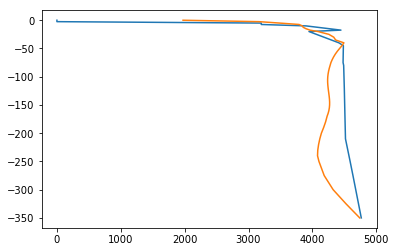

In [20]:
ant.ds['AK135_SV_LITH'] = ( ('AN_Z'), 
                           ant.change_coord(ant.ds['AK135_SV'], ant.ds['AK135_Z'], ant.ds['AN_Z'], axis=-1) )

An = ant.ds['AN_S'].mean(dim=['X', 'Y'])*km

plt.plot(ant.ds['AK135_SV_LITH'], -ant.ds['AN_Z']/km, An, -ant.ds['AN_Z']/km)
plt.show()

We set up a toy example. We would like to use AK135 to calculate the perturbation in AN1-S, but only for West Antarctica. We have a shapefile that defines the area we are interested in: 

In [21]:
ant.ds['WEST_ANTARCTICA'] = (('Y', 'X'), x$
                            0 < ant.assign_shape('../data/west_antarctica_defined.shp', 'Land'))

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


We don't worry about the warning. There are probably some crossing vertecies somewhere in the coast line. 

We use ´where´ to only select cells where `ant.ds['WEST_ANTARCTICA']` is `TRUE`. Here, we use index to select depth slice. 

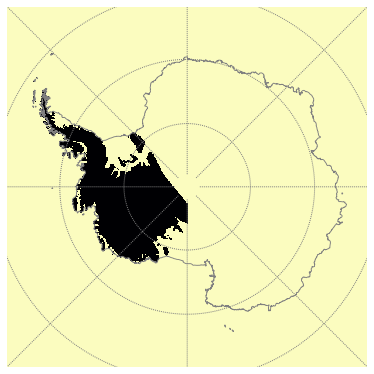

In [22]:
ant.map_grid(ant.ds['WEST_ANTARCTICA'], cmap='magma_r', figsize=(5,5))

#3D from vector import

#Subsampling lo res with high res

We can use this boolean grid to select parts of datasets:

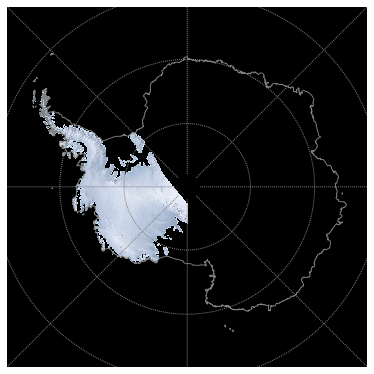

In [23]:
ant.map_grid(ant.ds['RGB_RASTER'].where(ant.ds['WEST_ANTARCTICA']), figsize=(5,5))

In [24]:
ant.ds['WEST_SEL'] = ant.ds['AN_S'].where(ant.ds['WEST_ANTARCTICA'])

We can also import 1-band rasters, eg Bedmap ice sheet thickness:

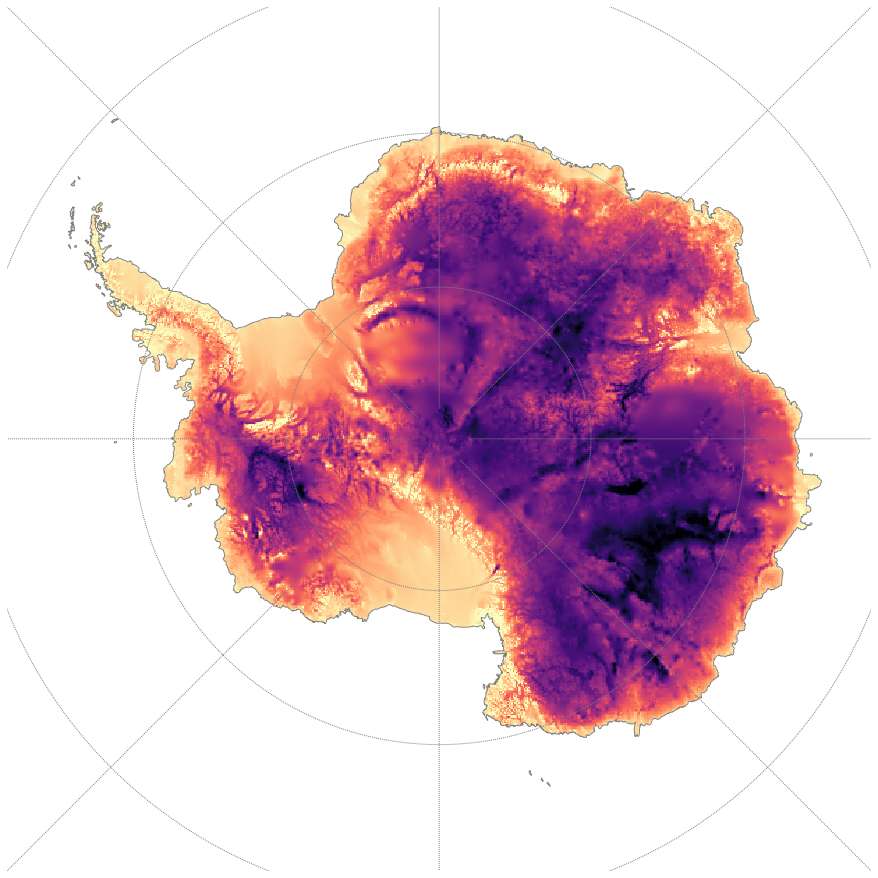

In [25]:
ant.ds['ICE'] = (('Y', 'X'), 
                ant.read_raster('../../../data/bedmap2_tiff/bedmap2_thickness.tif', no_data = 32767.) )

ant.map_grid(ant.ds['ICE'], cmap='magma_r')

We now have populated our grid object with a number of datasets: 

In [26]:
ant.ds

<xarray.Dataset>
Dimensions:          (AK135_Z: 145, AN_Z: 51, RGB: 3, X: 620, Y: 620, Z: 5)
Coordinates:
  * X                (X) float32 -3100000.0 -3089983.8 ... 3089983.8 3100000.0
  * Y                (Y) float32 3100000.0 3089983.8 ... -3089983.8 -3100000.0
  * Z                (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB              (RGB) <U1 'R' 'G' 'B'
    XV               (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    YV               (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lat              (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lon              (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
  * AN_Z             (AN_Z) float64 0.0 2.5e+03 5e+03 ... 3e+05 3.25e+05 3.5e+05
  * AK135_Z          (AK135_Z) float64 0.0 3e+03 3e+03 ... 6.32e+06 6.371e+06
Data variables:
    RGB_RASTER       (Y, X, RGB) float64 0.4941 0.6706 0.8196 ... 0.6353 0.7961
    AN_S             (Y, X, A

We can save data arrays as netCDF or GMT grids: 

In [27]:
ant.grid_to_grd(ant.ds['RGB'], save_name='rgb.nc')

Save to geotiff: 

In [28]:
ant.ds['RGB_RASTER'].shape

(620, 620, 3)

In [29]:
ant.grid_to_raster('RGB_RASTER', save_name ='rgb.tif')
ant.grid_to_raster('ICE', save_name ='ice.tif')

3080506

Saving the complete class object can also be handy: 

In [30]:
import pickle
pickle.dump(ant, open( "ant.p", "wb" ))

In [31]:
ant = None
ant.ds

AttributeError: 'NoneType' object has no attribute 'ds'

In [5]:
import pickle
ant = pickle.load( open( "ant.p", "rb" ) )
print(ant.ds)
print(ant.nn)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 620, Y: 620, Z: 5)
Coordinates:
  * X        (X) float32 -3100000.0 -3089983.8 ... 3089983.8 3100000.0
  * Y        (Y) float32 3100000.0 3089983.8 3079967.8 ... -3089983.8 -3100000.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    YV       (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lat      (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
    lon      (Y, X) float32 dask.array<shape=(620, 620), chunksize=(62, 62)>
Data variables:
    *empty*
(620, 620)


Sometimes a json file with the parameters is useful: 

In [6]:
ant.save_info(file_name='ant.json')

{'res': [10000, 10000],
 'depths': [0.0, 8000.0, 16000.0, 40000.0, 350000.0],
 'x1y1x2y2': (-3100000, 3100000, 3100000, -3100000),
 'wsen': (-3100000, -3100000, 3100000, 3100000),
 'left': -3100000,
 'up': 3100000,
 'right': 3100000,
 'down': -3100000,
 'ul': (-3100000, 3100000),
 'ur': (3100000, 3100000),
 'lr': (3100000, -3100000),
 'll': (-3100000, -3100000),
 'nx': 620,
 'ny': 620,
 'nn': (620, 620),
 'transform': Affine(10000.0, 0.0, -3100000.0,
        0.0, -10000.0, 3100000.0),
 'coord_d_type': "<class 'numpy.float32'>",
 'ds': 'xarray dataset',
 'nz': 5,
 'shape2': (620, 620),
 'shape3': (620, 620, 5),
 'xv': [-3100000.0, 3100000.0, -3100000.0, 3100000.0],
 'yv': [3100000.0, 3100000.0, -3100000.0, -3100000.0],
 'crs_src': '+init=epsg:4326',
 'crs': '+init=epsg:3031',
 'lon': [-45.0, 45.0, -135.0, 135.0],
 'lat': [-51.150660081857,
  -51.150660081857,
  -51.150660081857,
  -51.150660081857]}

Or the frame in ascii format, for some GIS applications. This is a first example of a suite of export functions used to extract data from the grid. E.g. Red channel from RGB raster: 

In [9]:
ant.grid_to_ascii(ant.ds['RGB_RASTER'][:,:,1])

2690271

In [10]:
download('http://www.seismolab.org/model/antarctica/lithosphere/AN1-CRUST.tar.gz', 
                  'lithosphere/AN1-CRUST.tar.gz')

File lithosphere/AN1-CRUST.tar.gz already exists.
Saved:  lithosphere/AN1-CRUST.tar.gz


{}